In [1]:
!pip install faiss-gpu pytorch-metric-learning
from fastai.vision.all import *
import logging
import pytorch_metric_learning
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning import losses, miners, samplers, testers, trainers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
DP = True if torch.cuda.device_count() > 1 else False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 7.6 MB/s eta 0:00:00


In [2]:
class CustomModel(nn.Module):
    def __init__(self, encoder, head):
        super().__init__()
        self.encoder = encoder
        self.head = head

    def forward(self, x):
        x = self.encoder(x)
        embeddings = self.head.embedding(x) 
        classifications = self.head.classifier(embeddings)  
        return embeddings, classifications

backbone=efficientnet_v2_s(weights="DEFAULT")
encoder = create_body(backbone)
embedding = nn.Sequential(
    AdaptiveConcatPool2d(),
    Flatten(),
    LinBnDrop(2560, 1024, bn=True, p=0.25, act=nn.SiLU(inplace=True)),
    LinBnDrop(1024, 512, bn=True, p=0.25, act=nn.SiLU(inplace=True)),
    LinBnDrop(512, 256, bn=True, p=0.5),
)

# 创建分类器
classifier = LinBnDrop(256, 37, bn=True, p=0.5, act=None)
# 创建模型
head = nn.Sequential()
# 添加 embedding 层
head.add_module('embedding', embedding)

# 添加 SiLU 激活函数
# head.add_module('silu', nn.SiLU(inplace=True))
# 添加 classifier 层
head.add_module('classifier', classifier)
apply_init(head, nn.init.kaiming_normal_)

model=torch.nn.DataParallel(CustomModel(encoder, head)) if DP else CustomModel(encoder, head)
def siamese_splitter(model):
    return [params(model.module.encoder), params(model.module.head)] if DP else [params(model.encoder), params(model.head)]

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:05<00:00, 14.9MB/s]


In [3]:
head

Sequential(
  (embedding): Sequential(
    (0): AdaptiveConcatPool2d(
      (ap): AdaptiveAvgPool2d(output_size=1)
      (mp): AdaptiveMaxPool2d(output_size=1)
    )
    (1): fastai.layers.Flatten(full=False)
    (2): LinBnDrop(
      (0): BatchNorm1d(2560, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.25, inplace=False)
      (2): Linear(in_features=2560, out_features=1024, bias=False)
      (3): SiLU(inplace=True)
    )
    (3): LinBnDrop(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.25, inplace=False)
      (2): Linear(in_features=1024, out_features=512, bias=False)
      (3): SiLU(inplace=True)
    )
    (4): LinBnDrop(
      (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=512, out_features=256, bias=False)
    )
  )
  (classifier): LinBnDrop(
    (0): BatchNorm1d(

In [4]:
#model

In [5]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers,regularizers
from torchvision import datasets, transforms
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
from collections import defaultdict
import random

def get_image_files_sample(path):
    files = get_image_files(path)
    label_pattern = r'(.+)_\d+.jpg$'
    label_func = using_attr(RegexLabeller(label_pattern), 'name')
    label_to_files = defaultdict(list)
    for file in files:
        label = label_func(file)
        label_to_files[label].append(file)
    sampled_files = []
    for files in label_to_files.values():
        sampled_files.extend(random.sample(files, min(50, len(files))))
    return sampled_files

pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files_sample, 
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224))
loaders = pets.dataloaders("/kaggle/input/the-oxfordiiit-pet-dataset/images")

In [6]:
#len(loaders.vocab)

In [7]:
#loaders.train.show_batch(max_n=6, nrows=2)

In [8]:
#loaders.valid.show_batch(max_n=6, nrows=2)

In [9]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low=0)
loss_func = losses.TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
mining_func = miners.TripletMarginMiner(margin=0.2, distance=distance, type_of_triplets="semihard")
classification_loss = torch.nn.CrossEntropyLoss()

def mined_loss(miner, loss_func):
    def loss(embeddings, labels):
        mined = miner(embeddings, labels)
        return loss_func(embeddings, labels, mined)
    return loss
  
my_loss = mined_loss(miner = mining_func, loss_func = loss_func)

class CombinedLoss(nn.Module):
    def __init__(self, embed_loss_func, class_loss_func, without_embed=False, without_ce=False):
        super().__init__()
        self.embed_loss_func = embed_loss_func
        self.class_loss_func = class_loss_func
        self.without_embed = without_embed
        self.without_ce = without_ce
    def forward(self, preds, target):
        embeddings, classifications = preds
        embed_loss = self.embed_loss_func(embeddings, target)
        class_loss = self.class_loss_func(classifications, target)
        if self.without_embed:
            return class_loss
        elif self.without_ce:
            return embed_loss
        else:
            return embed_loss + class_loss

combined_loss = CombinedLoss(my_loss, classification_loss)

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score
def accuracy(inp, targ, axis=-1):
    "Compute accuracy with `targ` when `pred` is bs * n_classes"
    pred,targ = flatten_check(inp[-1].argmax(dim=axis), targ)
    return (pred == targ).float().mean()

def precision(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return precision_score(targ, pred, average='macro',zero_division=1)

def recall(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return recall_score(targ, pred, average='macro',zero_division=1)

def f1score(inp, targ):
    pred = inp[-1].argmax(dim=-1).detach().cpu().numpy()
    targ = targ.detach().cpu().numpy()
    return f1_score(targ, pred, average='macro')

learn=Learner(loaders, 
              model,
              loss_func=combined_loss,
              splitter=siamese_splitter,
              cbs=[ShowGraphCallback],
              metrics=[accuracy,precision,recall,f1score])

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,5.134157,3.302307,0.189189,0.432172,0.284053,0.127060,00:14
1,4.529515,2.197340,0.562162,0.689728,0.605432,0.485228,00:11
2,3.761594,1.270831,0.745946,0.792831,0.784078,0.677054,00:11
3,2.997996,0.798462,0.835135,0.850437,0.845584,0.777445,00:11
4,2.344412,0.606219,0.862162,0.876560,0.866927,0.808667,00:11
5,1.840215,0.514177,0.864865,0.867402,0.870050,0.804996,00:11
6,1.468596,0.490273,0.872973,0.873164,0.883645,0.825664,00:11
7,1.183148,0.467791,0.872973,0.873121,0.881756,0.819623,00:11
8,0.991603,0.469239,0.875676,0.897198,0.883628,0.831744,00:11
9,0.848481,0.422996,0.872973,0.870544,0.876930,0.807352,00:11


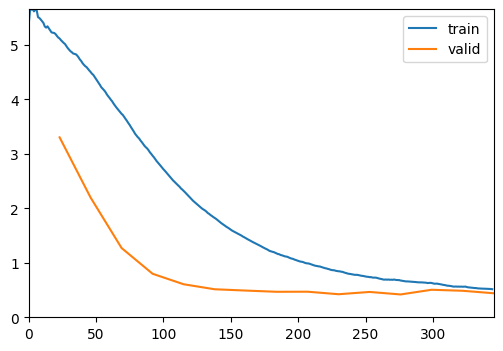

epoch,train_loss,valid_loss,accuracy,precision,recall,f1score,time
0,0.379528,0.420498,0.889189,0.887050,0.887206,0.827437,00:15
1,0.373205,0.434218,0.878378,0.884801,0.882937,0.815843,00:14
2,0.333109,0.440695,0.889189,0.900115,0.894942,0.837975,00:15
3,0.326756,0.417872,0.902703,0.903985,0.910629,0.857128,00:15
4,0.326481,0.453779,0.894595,0.902845,0.892608,0.838005,00:14
5,0.315230,0.426037,0.918919,0.924431,0.928795,0.889533,00:15
6,0.294774,0.414534,0.910811,0.914095,0.914929,0.863684,00:14
7,0.269802,0.439398,0.886486,0.883809,0.895625,0.829528,00:14
8,0.249135,0.418689,0.897297,0.897380,0.903252,0.840006,00:15
9,0.233110,0.426539,0.905405,0.905804,0.913350,0.859301,00:14


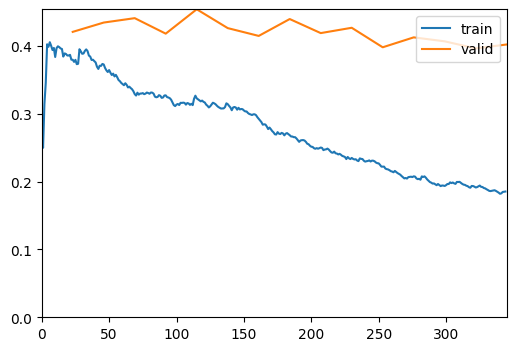

In [11]:
learn.fine_tune(15,freeze_epochs=15)

In [12]:
hooks = Hooks(model.module.head.embedding if DP else model.head.embedding, lambda m,i,o: o)
ftrs = tensor([]).cuda()
for i in learn.dls.valid:
    learn.model(i[0])
    hooks_output = nn.Flatten()(hooks.stored[-1])
    hooks_output = hooks_output.to(ftrs.device)  # move hooks_output to the same device as ftrs
    ftrs = torch.cat((ftrs, hooks_output))

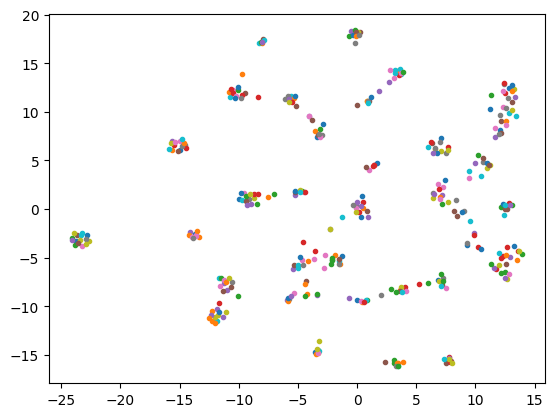

In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
output = tsne.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')

2024-05-01 17:29:14.878613: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 17:29:14.878763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 17:29:15.009200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


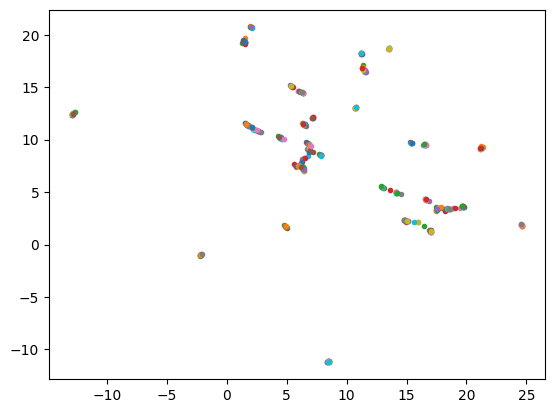

In [14]:
from umap import UMAP
umap = UMAP(n_components=2)
output = umap.fit_transform(ftrs.cpu().detach().numpy())
for i in range(len(output)):
    plt.plot(output[i, 0], output[i, 1], '.')